In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = "localhost" ,   
    username = "root",
    password = "Bhu@5678",
    database = "ecommerce"
    
)

cur = db.cursor()

BASIC QUERIES

1.List all unique cities where the customers are located

In [9]:

query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
#print(data)

for city in data:
    print(city) 

('franca',)
('sao bernardo do campo',)
('sao paulo',)
('mogi das cruzes',)
('campinas',)
('jaragua do sul',)
('timoteo',)
('curitiba',)
('belo horizonte',)
('montes claros',)
('rio de janeiro',)
('lencois paulista',)
('caxias do sul',)
('piracicaba',)
('guarulhos',)
('pacaja',)
('florianopolis',)
('aparecida de goiania',)
('santo andre',)
('goiania',)
('cachoeiro de itapemirim',)
('sao jose dos campos',)
('sao roque',)
('camacari',)
('resende',)
('sumare',)
('novo hamburgo',)
('sao luis',)
('sao jose',)
('santa barbara',)
('ribeirao preto',)
('ituiutaba',)
('taquarituba',)
('sao jose dos pinhais',)
('barrinha',)
('parati',)
('dourados',)
('trindade',)
('cascavel',)
('fortaleza',)
('brasilia',)
('pelotas',)
('porto alegre',)
('salto',)
('jundiai',)
('cacapava',)
('sao vicente',)
('uberlandia',)
('botelhos',)
('sao goncalo',)
('araucaria',)
('nova iguacu',)
('areia branca',)
('campos dos goytacazes',)
('sao carlos',)
('itajuba',)
('cruz das almas',)
('vassouras',)
('feira de santana',)
(

2.count the no.of orders placed in the year 2017

In [ ]:

query = """ select count(order_id) from orders where year(order_purchase_timestamp)='2017' """
cur.execute(query)
data = cur.fetchall()
print("Total Orders in 2017 are:",data[0][0])

Total Orders in 2017 are: 90202


3.Find the total sales per category

In [ ]:

query = """ select pr.product_category,round(sum(payment_value),2) sales
            from products  pr
            join order_items oi on pr.product_id = oi.product_id
            join payments p on p.order_id = oi.order_id 
            group by pr.product_category """
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data,columns = ['Product_category','Total_Sales'])
df

4.Calculate the percentage of orders that were paid in installments.

In [ ]:
query = """ select (sum(case when payment_installments >=1 then 1 else 0 end) * 100) / count(order_id) Percentage
            from payments"""
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

5.count the no.of customers from each state

In [ ]:

query = """ select customer_state, count(customer_id) Total_customers from customers group by customer_state """
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data, columns = ['State','Total_Customers'])
#print(df)
df = df.sort_values(by = 'Total_Customers',ascending=False)
sns.barplot(df,x = 'State', y = 'Total_Customers')


INTERMEDIATE QUERIES

1. Calculate the number of orders per month in 2018

In [ ]:

query = """ select monthname(order_purchase_timestamp) Month , count(order_id) Number_of_Orders
            from orders where year(order_purchase_timestamp) = 2018 group by Month """
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data, columns = ['Month','order_count'])
o = ["January","February","March","April","May","June","July","August","Septmeber","October","November","December"]
res = sns.barplot(df, x = "Month", y = "order_count", order = o)

plt.xticks(rotation = 90)
res.bar_label(res.containers[0]) # to show the value of the bar
plt.title("Number Of Orders Per Month in 2018")
plt.show()


2.Find the average number of products per order grouped by customer city

In [ ]:

query = """ with count_per_order as
                ( select order_id, count(product_id) product_count
                from order_items 
                group by order_id)
                select customer_city, avg(co.product_count) avg_products_per_order
                from  customers c 
                join orders o on o.customer_id = c.customer_id
                join count_per_order co on co.order_id = o.order_id
                group by customer_city order by avg_products_per_order desc """
cur.execute(query)
data = cur.fetchall()
data

3.Calculate the percentage of toatl revenue contributed by each product category

In [ ]:

query = """ select pr.product_category ,
            round((sum(p.payment_value)/(select sum(payment_value) from payments))*100,2)sales_percentage
            from products  pr
            join order_items oi on pr.product_id = oi.product_id
            join payments p on p.order_id = oi.order_id 
            group by pr.product_category order by sales_percentage desc  """
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data, columns = ['Product_category','Sales_percentage'])
df

4.Identify the correlation between the product price and the no.of times the product has been purchased

In [ ]:

query = """ select pr.product_category, count(oi.product_id) Purchase_count , round(avg(oi.price),2) price
            from order_items oi 
            join products pr on pr.product_id = oi.product_id
            group by pr.product_category """
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['Product','Order_Count','Price'])
print(df)

#finding correlation coefficient
arr1 = np.array(df['Price'])
arr2 = np.array(df['Order_Count'])

c = np.corrcoef(arr1,arr2)
print("The correlation between the price and the no.of times the product has been purchased is ",c[0,1])

5.Calculate the total revenue generated by each seller and rank them by revenue

In [ ]:

query = """ with Revenue_Per_Seller as (
            select oi.seller_id, round(sum(payment_value),2) total_revenue
            from  order_items oi 
            join payments p on p.order_id = oi.order_id
            group by oi.seller_id)
            select seller_id, total_revenue,
            dense_rank() over (order by total_revenue desc)  as Seller_Rank
            from Revenue_Per_Seller"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data,columns = ['Seller_Id','Revenue','Seller_Rank'])
df



ADVANCED QUERIES

1.Calculate the moving average of order values for each customer over their order history

In [ ]:

query = """select customer_id, order_purchase_timestamp, payment,
            avg(payment) over(partition by customer_id order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from
            (select orders.customer_id, orders.order_purchase_timestamp, 
            payments.payment_value as payment
            from payments join orders
            on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data)
df

2.Calculate the cumulative sales per month for each year.

In [ ]:

query = """ with Sales_Per_Month as
            (select year(o.order_purchase_timestamp) Year ,month(o.order_purchase_timestamp) Month,
            round(sum(p.payment_value),2) Payment
            from orders o
            join payments p on p.order_id = o.order_id
            group by Year,Month order by Year,Month)
            select Year,Month, Payment, sum(Payment) over(order by Year,Month) Cumulative_Payment
            from Sales_Per_Month"""

cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['Year','Month','Sales','Cumulative_Sales'])
df

3.Calculate the year-over-year growth rate of total sales.

In [ ]:

query = """ select years,Sales, 
            ((Sales-lag(Sales,1,0)over(order by Years))/lag(Sales,1,0)over(order by Years))*100  Sales_Growth
            from(select year(o.order_purchase_timestamp) Years , round(sum(p.payment_value),2) Sales
            from orders o 
            join payments p on p.order_id = o.order_id
            group by Years order by Years) as a"""

cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns = ['Years','Sales','Sales_Growth'])
df


4.Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [10]:
 
query = """ with a as 
            (select customer_id, min(order_purchase_timestamp) first_order
            from orders
            group by customer_id order by customer_id),
            b as
            (select a.customer_id, first_order ,count(distinct orders.order_purchase_timestamp) orders_within_6mon
            from a 
            join orders on orders.customer_id = a.customer_id
            and orders.order_purchase_timestamp > first_order
            and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
            group by a.customer_id)
            select 100*(count(a.customer_id)/count(b.customer_id))
            from a left join b on a.customer_id = b.customer_id"""

cur.execute(query)
data = cur.fetchall()
data


[(None,)]

5.Identify the top 3 customers who spent the most money in each year.

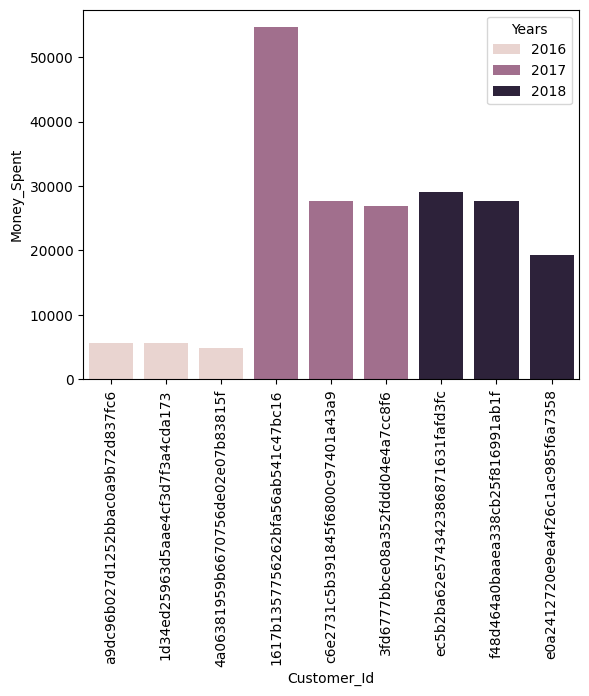

In [19]:
query = """ with ranked_customers as
            (select Years,Customer_id,Money_Spent,
            rank() over(partition by years order by Money_Spent desc) as Top_Customers 
            from
            (select o.customer_id,year(o.order_purchase_timestamp) Years ,sum(p.payment_value) Money_Spent
            from orders o
            join payments p on p.order_id = o.order_id
            group by o.customer_id,years
            order by years, Money_Spent desc) as a
            )
            select * from ranked_customers
            where Top_Customers <=3"""
cur.execute(query)
data = cur.fetchall()
#data

df = pd.DataFrame(data, columns = ['Years','Customer_Id','Money_Spent','Rank'])
df
sns.barplot(df,x = 'Customer_Id', y = 'Money_Spent', hue = 'Years')
plt.xticks(rotation = 90)
plt.show()
